# Info 370 HW 07

Name: Ella Kim   

*Citations are hyperlinked*

## Who will win the elections?
#### 1

In [2]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

#load in data
df_elect = pd.read_csv('/home/jovyan/lost+found/INFO_370/us-elections_2000-2020.csv.bz2', sep="\t")

#sanity checks
# print # cols
cols = df_elect.shape[1]
print("Number of columns: " + str(cols))
# print # rows
rows = df_elect.shape[0]
print("Number of rows: " + str(rows))
print(df_elect.head(5)) #sanity check
# make df of total count of nulls in each col & print results
df_null = df_elect.isnull().sum() # income & population: 6762, candidatevotes: 4

Number of columns: 22
Number of rows: 37390
   FIPS  year    state state2   county     office       candidate       party  \
0  1001  2000  Alabama     AL  Autauga  President         Al Gore    democrat   
1  1001  2000  Alabama     AL  Autauga  President  George W. Bush  republican   
2  1001  2004  Alabama     AL  Autauga  President      John Kerry    democrat   
3  1001  2004  Alabama     AL  Autauga  President  George W. Bush  republican   
4  1001  2008  Alabama     AL  Autauga  President    Barack Obama    democrat   

   candidatevotes  totalvotes  ...  LND010200D  EDU695209D  EDU600209D  \
0          4942.0       17208  ...      604.45        2285       31469   
1         11993.0       17208  ...      604.45        2285       31469   
2          4758.0       20081  ...      604.45        2285       31469   
3         15196.0       20081  ...      604.45        2285       31469   
4          6093.0       23641  ...      604.45        2285       31469   

   POP010210D  POP220210

#### 2

In [3]:
# fill NaN for columns that have existing values before it in the same county
df_elect['income'] = df_elect.groupby("FIPS").income.fillna(method = 'ffill')
df_elect['population'] = df_elect.groupby("FIPS").population.fillna(method = 'ffill')

# there are still NaN values because some counties do not have any existing/previous values, sanity check
df_elect.isna().sum()

print(df_elect.population[df_elect.year == 2020])

# therefore, professor said to eliminate rows that still have NaN for those
df_elect.dropna(inplace=True) 

10        55243.0
11        55243.0
22       207601.0
23       207601.0
34        25806.0
           ...   
37365     20682.0
37376      8165.0
37377      8165.0
37388      7220.0
37389      7220.0
Name: population, Length: 6222, dtype: float64


#### 3
[Citation for function setup](https://stackoverflow.com/questions/48819644/pandas-comparing-rows-within-groups)

In [4]:
# filter for only 2020 year
df_2020 = df_elect[df_elect.year == 2020]
total_obs = df_2020.shape[0]

# define function that will return binary value for outcome for that county
def getDem(county):
    return 1 if (county.party[county.candidatevotes == county.candidatevotes.max()].values) == "democrat" else 0

# apply the function to grouped df by county
outcome = df_2020.groupby('FIPS', group_keys=False).apply(getDem).values

# after doing some of the other problems, it was best to just keep democrat values of the county
df_2020_dem = df_2020[df_2020.party == 'democrat']

# make copy for warning message in next line & add to df as new column
df_2020_dem = df_2020_dem.copy()
df_2020_dem['outcome'] = outcome

#### 4

[Citation for .drop steps](https://thispointer.com/python-pandas-how-to-drop-rows-in-dataframe-by-conditions-on-column-values/)

In [5]:
# define function to get the column computation
def getProportion(num, denom, ispercent):
    result = num / denom
    if ispercent == True:
        result = result * 100
    else:
        result = result / 1000
    return result

# after running this on all the differnt columns, there is 0s in land area that result in inf, so we remove 
# all of those before so that the same warnings do not show up
indexOfLand = df_2020_dem[df_2020_dem['LND010200D'] == 0].index
df_2020_dem.drop(indexOfLand, inplace=True)
indexOfPop = df_2020_dem[df_2020_dem['population'] == 0].index
df_2020_dem.drop(indexOfPop, inplace =True)
# now can safely compute the different auxiliary variables
df_2020_dem['popdensity'] = getProportion(df_2020_dem.population.values, df_2020_dem.LND010200D.values, False)
df_2020_dem['popdensity'].tolist() # had inf, so made section before to catch 0s

total_minority = df_2020_dem.POP250210D.values + df_2020_dem.POP320210D.values + df_2020_dem.POP400210D.values 
df_2020_dem['minorityperc'] = getProportion(total_minority, df_2020_dem.population.values, True)

df_2020_dem['collegeperc'] = getProportion(df_2020_dem.EDU695209D.values, df_2020_dem.population.values, True)

#### 5

In [6]:
# run OLS, print summary values
m = smf.ols("outcome ~ popdensity + minorityperc + collegeperc + income + C(region)", data=df_2020_dem).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     352.0
Date:                Sun, 16 Jan 2022   Prob (F-statistic):               0.00
Time:                        08:28:46   Log-Likelihood:                -416.07
No. Observations:                3058   AIC:                             848.1
Df Residuals:                    3050   BIC:                             896.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2228      0.023     -9.785      0.000      -0.267      -0.178
C(region)[T.northeast]     0.1029      0.022      4.633      0.000       0.059       0.146
C(region)[T.south]        -0.1263      0.013     -9.553      0.000      -0.152      -0.100
C(region)[T.west]          0.0165      0.017      0.985      0.325      -0.016       0.049
popdensity                 0.0015      0.004      0.353      0.724      -0.007       0.010
minorityperc               0.0097      0.000     32.193      0.000       0.009       0.010
collegeperc                0.0763      0.003     25.167      0.000       0.070       0.082
income                 -1.134e-06   5.73e-07     -1.979      0.048   -2.26e-06   -1.04e-08
==============================================================================
Omnibus:                      430.642   Durbin-Watson:                   1.819
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              733.727
Skew:                           0.930   Prob(JB):                    4.71e-160
Kurtosis:                       4.516   Cond. No.                     2.14e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.14e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 6

Interpreting the coefficients, when these variables are 0/null(for region), there is a negative impact for democrat's vote share by ~0.22. For varible coefficients, for every increase in a county's region of NE or West, there is an increase in democrat's vote share by ~-0.10 and -0.02 respectively, but when the county added is in the South there is a decrease in democrat's vote share by ~0.13. For every increase in 1 unit for population density, minority percentage, or college percentage, there is an increase in democrat's vote share by ~0.002, 0.010, 0.076 respectively, while income results in a decrease of ~-0.000001 for every increase in 1 dollar. However, when viewing the p-values, the West region and population density are not statistically significant coefficients on a significant value of 0.05 (95% confidence). In other words, we cannot rule out the possibility that they do not have any impact on the democrat's vote share, so their coefficients should no longer be considered. 

R^2 shows that there is not a very strong correlation between all these variables and democrat's vote share, but, on a side note, it could have been affected significantly with the variables that are not statistically significant.

## Predict AirBnB Price
#### 1

In [7]:
#load in data
df_airb = pd.read_csv('/home/jovyan/lost+found/INFO_370/airbnb-beijing-listings.csv.bz2', sep=",", usecols = ["accommodates", "price", "room_type", "bedrooms"])

#sanity checks
# print # cols
cols = df_airb.shape[1]
print("Number of columns: " + str(cols))
# print # rows
rows = df_airb.shape[0]
print("Number of rows: " + str(rows))
print(df_airb.head(5)) #sanity check
# make df of total count of nulls in each col & print results
df_null = df_airb.isnull().sum() # bedrooms: 114

Number of columns: 4
Number of rows: 38814
         room_type  accommodates  bedrooms      price
0  Entire home/apt             9       3.0    $831.00
1     Private room             2       1.0  $1,197.00
2  Entire home/apt             2       1.0    $598.00
3  Entire home/apt             2       1.0    $598.00
4  Entire home/apt             2       1.0    $598.00


#### 2

In [8]:
# A
# change price to numerical values
df_airb = df_airb.copy()
df_airb['price'] = df_airb['price'].apply(lambda x: x.replace('$', ''))
df_airb['price'] = df_airb['price'].apply(lambda x: x.replace(',', ''))
df_airb['price'] = pd.to_numeric(df_airb['price'])


# B 
# remove any NaN (bedroom had NaN)
df_airb.dropna(inplace=True) 
df_airb.isnull().sum() # sanity check, other variables did not have any weird/invalid values
# when doing log transformations, there cannot be 0, so I had to remove 0 in price
df_airb = df_airb[df_airb.price != 0]

#### 3

Original Prices


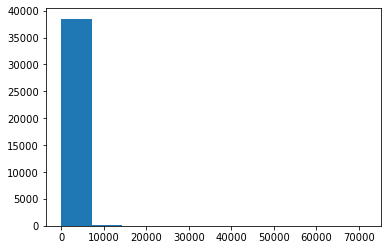

Ln transformation of Prices


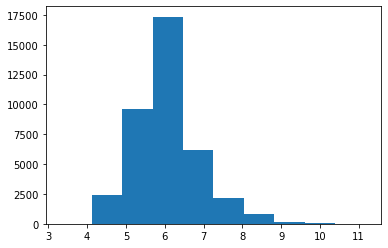

In [9]:
# plot original prices with label to keep track
print("Original Prices")
plt.hist(df_airb.price)
plt.show()

# plot ln prices and label
print("Ln transformation of Prices")
plt.hist(np.log(df_airb.price))
plt.show()

# make new column in df with ln transformation for OLS later
df_airb['ln_price'] = np.log(df_airb.price)

The distribution is so obviously right-skewed, it definitely needs to have a log-transformation. After the transformation, it does not look as normal as I would have expected as it is still right-skewed, but it is definitely more normal than the original prices.

#### 4

In [10]:
# not sure why, but would not work before I changed bedroom to int
df_airb.bedrooms = df_airb.bedrooms.values.astype(int)

# from txbk, set category value in accordance to int value inequality/equality, and make into new ordered 
# categorical variable
df_airb["bedroom_cat"] = np.where(df_airb.bedrooms == 0, "0", df_airb.bedrooms)
df_airb["bedroom_cat"] = np.where(df_airb.bedrooms == 1, "1", df_airb.bedrooms)
df_airb["bedroom_cat"] = np.where(df_airb.bedrooms == 2, "2", df_airb.bedrooms)
df_airb["bedroom_cat"] = np.where(df_airb.bedrooms == 3, "3", df_airb.bedrooms)
df_airb["bedroom_cat"] = np.where(df_airb.bedrooms >= 4, "4+", df_airb.bedrooms)

#### 5

In [11]:
# run OLS, print summary values, is not -12.62 for bedroom count 1, but is close so probably difference 
# in cleaning procedure
m_bed = smf.ols("price ~ C(bedroom_cat)", data=df_airb).fit()
m_bed.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     1087.
Date:                Sun, 16 Jan 2022   Prob (F-statistic):               0.00
Time:                        08:28:55   Log-Likelihood:            -3.4145e+05
No. Observations:               38691   AIC:                         6.829e+05
Df Residuals:                   38686   BIC:                         6.830e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              448.8851    107.381      4.180      0.000     238.416     659.355
C(bedroom_cat)[T.1]    -10.8376    107.871     -0.100      0.920    -222.267     200.592
C(bedroom_cat)[T.2]    295.9590    109.020      2.715      0.007      82.277     509.641
C(bedroom_cat)[T.3]    746.0202    112.190      6.650      0.000     526.124     965.916
C(bedroom_cat)[T.4+]  2166.9236    112.218     19.310      0.000    1946.973    2386.874
==============================================================================
Omnibus:                    95690.629   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1516867980.268
Skew:                          26.751   Prob(JB):                         0.00
Kurtosis:                     971.530   Cond. No.                         35.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation of coefficients: when the bedroom is 0, price is ~\\$448.89, and for every increase of a 1 bed, there is a decrease in price of ~-\\$10.84. For every addition of a 2, 3, or 4+ bedroom airbnb, there is an increase in price of ~\\$295.96, \\$746.02, and \\$2166.92 respectively. The p-values are all < 0.05 (a significant value 0.05, or in other words 95% confidence), except for bedroom count of 1, so that coefficient is no longer statistically significant. 

Interpretation of R^2: it is 0.101, which is a very low R^2 as it is much closer to 0 than 1, meaning there is not a strong correlation, if anything it is closer to having no correlation as there is only a slight correlation. 

#### 6

In [12]:
# run OLS, print summary values for ln_price
m_lnprice = smf.ols("ln_price ~ C(bedroom_cat)", data=df_airb).fit()
m_lnprice.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     4555.
Date:                Sun, 16 Jan 2022   Prob (F-statistic):               0.00
Time:                        08:28:55   Log-Likelihood:                -40101.
No. Observations:               38691   AIC:                         8.021e+04
Df Residuals:                   38686   BIC:                         8.025e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                5.8117      0.045    130.594      0.000       5.724       5.899
C(bedroom_cat)[T.1]     -0.0322      0.045     -0.721      0.471      -0.120       0.055
C(bedroom_cat)[T.2]      0.5306      0.045     11.743      0.000       0.442       0.619
C(bedroom_cat)[T.3]      0.9396      0.046     20.208      0.000       0.848       1.031
C(bedroom_cat)[T.4+]     1.5924      0.047     34.240      0.000       1.501       1.684
==============================================================================
Omnibus:                     3919.550   Durbin-Watson:                   1.781
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17154.012
Skew:                           0.423   Prob(JB):                         0.00
Kurtosis:                       6.151   Cond. No.                         35.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation of coefficients: when the bedroom is 0, log price is ~5.81, and for every increase of a 1 bed, there is a decrease in log price of ~-0.03. For every addition of a 2, 3, or 4+ bedroom airbnb, there is an increase in log price of ~0.53, 0.94, and 1.59 respectively. The p-values are all < 0.05 (a significant value 0.05, or in other words 95% confidence), except for bedroom count of 1, so that coefficient is no longer statistically significant. Although the p-value did decrease significantly, it is still > 0.05

Interpretation of R^2: it is 0.320, which is a low R^2 as it is closer to 0 than 1, meaning there is not a slightly stronger correlation for log price than regular price (i.e. this is the model that behaves better in the sense of R^2), but it was not a huge increase.

#### 7

In [13]:
# from txbk, set category value in accordance to int value inequality/equality, and make into new 
# ordered categorical variable
df_airb["accom_cat"] = np.where(df_airb.accommodates == 1, "1", df_airb.accommodates)
df_airb["accom_cat"] = np.where(df_airb.accommodates == 2, "2", df_airb.accommodates)
df_airb["accom_cat"] = np.where(df_airb.accommodates == 3, "3", df_airb.accommodates)
df_airb["accom_cat"] = np.where(df_airb.accommodates >= 4, "4 and more", df_airb.accommodates)


# run OLS, print summary values for ln_price, adding room_type and accomodates
m_ln_all = smf.ols("ln_price ~ C(bedroom_cat) + C(room_type) + C(accom_cat)", data=df_airb).fit()
m_ln_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     3372.
Date:                Sun, 16 Jan 2022   Prob (F-statistic):               0.00
Time:                        08:28:56   Log-Likelihood:                -36363.
No. Observations:               38691   AIC:                         7.275e+04
Df Residuals:                   38681   BIC:                         7.283e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        5.5807      0.042    131.943      0.000       5.498       5.664
C(bedroom_cat)[T.1]              0.0576      0.041      1.418      0.156      -0.022       0.137
C(bedroom_cat)[T.2]              0.1956      0.042      4.699      0.000       0.114       0.277
C(bedroom_cat)[T.3]              0.5956      0.043     13.893      0.000       0.512       0.680
C(bedroom_cat)[T.4+]             1.2760      0.043     29.737      0.000       1.192       1.360
C(room_type)[T.Private room]    -0.3143      0.008    -41.875      0.000      -0.329      -0.300
C(room_type)[T.Shared room]     -0.9192      0.017    -53.894      0.000      -0.953      -0.886
C(accom_cat)[T.2]                0.3331      0.014     24.333      0.000       0.306       0.360
C(accom_cat)[T.3]                0.3978      0.017     23.526      0.000       0.365       0.431
C(accom_cat)[T.4 and more]       0.6237      0.016     39.710      0.000       0.593       0.655
==============================================================================
Omnibus:                     9228.818   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49972.776
Skew:                           1.044   Prob(JB):                         0.00
Kurtosis:                       8.161   Cond. No.                         41.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All of the coefficients are statistically significant except again for 1 bedroom (again, the p-value decreased significantly but is still < 0.05). While it made sense to me that a shared room should decrease the price, I was intially surprised that a private room would decrease the price, but then I realized that a private room would only mean a room not the airbnb house as a whole, so it would make sense to have a lower price. The other important trends is that the more bedrooms there are, the larger the coefficients which makes sense. The same pattern occurs for accommodates, which also makes sense. 

The relevant reference catrgories are 0-BR, Entire home/apt-RT, and 1-Accommodates. As for R^2, although it is an increase from the log price of only bedroom (i.e. is the model that behaves the best so far based on R^2), it is not a significantly greater increase as it is still less than 0.5, meaning the correlation is still not that strong.

#### 8

In [14]:
# get predicted values from df (having df of only variables or original does not matter)
yhat = m_ln_all.predict(df_airb)
print("First 5 observations and their predictions: \n" + str(yhat.head()))

First 5 observations and their predictions: 
0    6.799978
1    5.657081
2    5.971426
3    5.971426
4    5.971426
dtype: float64


#### 9

In [15]:
# compute RMSE
e_squared = (df_airb.ln_price - yhat)**2
mse = 1/df_airb.shape[0] * sum(e_squared)
rmse = np.sqrt(np.mean((np.log(abnb.price) - logPriceHat)**2))
#rmse = mse**1/2

# print result
print("RMSE = " + str(rmse) + ". In other words, typically, our log price predictions are off by " + str(rmse))

NameError: name 'abnb' is not defined

#### 10

In [ ]:
# get parameters/coeff
beta = m_ln_all.params
# put 1 or 0 unit for correct coefficients manually
X = np.column_stack([[1], [0], [1], [0], [0], [0], [0], [0], [0], [1]])
# compute predicted yhat
yhat_10 = X @ beta

# print results
print("Predicted log price for 2-bed, full house/apt, that accommodates 4 is " + str(yhat_10[0]))

# filter original df for variables only of conditions listed
find = df_airb[(df_airb.bedroom_cat == '2') & (df_airb.room_type == 'Entire home/apt') & (df_airb.accom_cat == '4 and more')]
yhat_10_check = m_ln_all.predict(find) # sanity check to see if manual way was correct, was correct